# Newsvendor Intro Example

In [150]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})


### Example 1: Intro example, max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

We formulate the Newsvendor problem with this framework, where we solve
\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \tau\\
		\text{subject to} & k^Tx  + \max\{-p^Tx,- p^Tu\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& x \geq 0.
	\end{array}
\end{equation}

In [151]:
# Formulate constants
n = 2
N = 500
test_perc = 0.99
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])
# k_tch = torch.tensor(k, requires_grad = True)
# p_tch = torch.tensor(p, requires_grad = True)

def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.4],[-0.4,0.1]])
    mu = np.array((1.1,1.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
# data = gen_demand_intro(N, seed=5)
data = gen_demand_intro(N, seed=5)

In [152]:
num_scenarios = 10
num_reps = int(N/10)
k_data = k + np.random.normal(0,1,(num_scenarios,n))
p_data = k_data + np.maximum(0,np.random.normal(0,1,(num_scenarios,n)))
p_data = np.vstack([p_data]*num_reps)
k_data = np.vstack([k_data]*num_reps)

In [131]:
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,a=init, b= init_bval, rho=0.3))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = cp.Parameter(2, value = k_data[0])
p = cp.Parameter(2, value = p_data[0])

objective = cp.Minimize(t)
constraints = [cp.maximum(-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])),-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(u@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) - (p@np.array([0, 1]))*(u@np.array([0, 1]))) + k@x_r <= t]
constraints += [x_r >= 0]
problem = lropt.RobustProblem(objective, constraints)
problem.solve()
print(problem.objective.value, x_r.value)

u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,a=result.A, b= result.b, rho=0.3))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = cp.Parameter(2, value = k_data[0])
p = cp.Parameter(2, value = p_data[0])

objective = cp.Minimize(t)
constraints = [cp.maximum(-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])),-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(u@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) - (p@np.array([0, 1]))*(u@np.array([0, 1]))) + k@x_r <= t]
constraints += [x_r >= 0]
problem = lropt.RobustProblem(objective, constraints)
problem.solve()
print(problem.objective.value, x_r.value)

4.332484766362926 [-2.22553603e-09  2.40546117e-02]
6.466851293238891 [ 4.84993818e-02 -2.93979727e-09]


In [153]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(
                                                    data=data))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = lropt.Parameter(2, data=k_data)
p = lropt.Parameter(2, data=p_data)

objective = cp.Minimize(t)
constraints = [cp.maximum(-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])),-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(u@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) - (p@np.array([0, 1]))*(u@np.array([0, 1]))) + k@x_r <= t]
constraints += [x_r >= 0]


eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)
target = -0.0
test_p = 0.9
s = 8

# setup intial A, b
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(np.cov(train.T))
init_bval = np.mean(train, axis=0)

np.random.seed(15)
#initn = 5*np.random.rand(n,2)
# initn = np.eye(n) + 5*np.random.rand(n,2)
# init_bvaln = np.mean(train, axis=0)
initn = sc.linalg.sqrtm(np.cov(train.T))
init_bvaln = np.mean(train, axis=0)
# Train A and b
result = prob.train(lr=0.001, train_size = False, num_iter=500, optimizer="SGD",seed=5, init_A=initn, init_b=init_bvaln, init_lam=0.1, init_mu=0.1,
                    mu_multiplier=1.001, kappa=0., init_alpha=0., test_percentage = test_p,save_history = True, quantiles = (0.4,0.6), lr_step_size = 50, lr_gamma = 0.5, random_init = True, num_random_init = 5, parallel = True, position = False, eta=0.3)
df = result.df
A_fin = result.A
b_fin = result.b

python(96453) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are know

In [154]:
# Grid search epsilon
eps_list = np.linspace(0.5, 2.5, 10)
result4 = prob.grid(epslst=eps_list, init_A=init,
                    init_b=init_bval, seed=8,
                    init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
dfgrid = result4.df

result5 = prob.grid(epslst=eps_list,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6))
dfgrid2 = result5.df

In [155]:
epslst =eps_list
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())

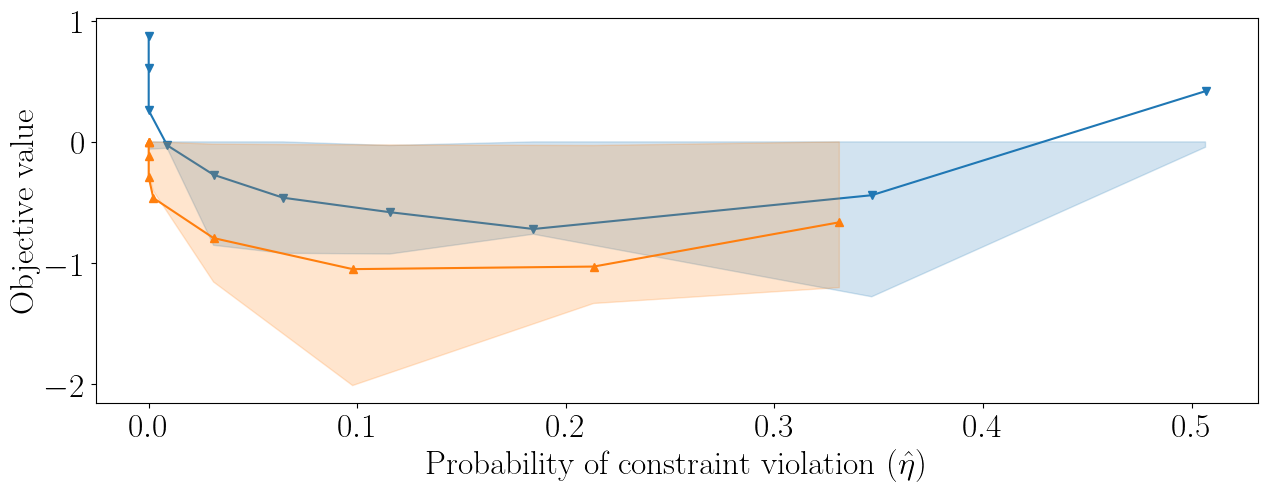

In [156]:
beg1, end1 = 0, 100
beg2, end2 = 0, 100
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.fill(np.append(dfgrid['Avg_prob_test'][beg1:end1],dfgrid['Avg_prob_test'][beg1:end1][::-1]), np.append(dfgrid['Lower_test'][beg1:end1],dfgrid['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)
# for ind in range(4):
#     plt.scatter(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[inds_standard[ind]], np.mean(np.vstack(
#         dfgrid['Test_val']), axis=1)[inds_standard[ind]], color="tab:green", s=50, marker="v", zorder=10)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Reshaped set", marker="^", zorder=1)
plt.fill(np.append(dfgrid2['Avg_prob_test'][beg2:end2],dfgrid2['Avg_prob_test'][beg2:end2][::-1]), np.append(dfgrid2['Lower_test'][beg2:end2],dfgrid2['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)
# for ind in [0, 2, 1, 3]:
#     plt.scatter(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[inds_reshaped[ind]], np.mean(
#         np.vstack(dfgrid2['Test_val']), axis=1)[inds_reshaped[ind]], color="black", s=50, marker="^")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.xscale("log")
# plt.ylim([-3, 1])
# minv, maxv = (-0.25,-0.1)
# minv, maxv = (-0.28,-0.17)
# plt.vlines(ymin=minv, ymax=maxv, x=prob_list[0], linestyles=":",
#            color="tab:red", label="Reference $\hat{\eta}$")
# for i in prob_list[1:]:
#     plt.vlines(ymin=minv, ymax=maxv, x=i, linestyles=":", color="tab:red")
# plt.legend(loc="upper right")
# plt.ylim([-0.275,-0.175])
plt.savefig("news_objective_vs_violations_new.pdf", bbox_inches='tight')

In [157]:
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
test_val_st = []
prob_val_st = []
test_val_re = []
prob_val_re = []
t_re = []
t_st = []
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(10):
        n = 2
        Amat = A_fin
        bvec = b_fin
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2, rho=eps_list[inds_reshaped[ind]], a = A_fin, b =b_fin))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = k_data[scene]
        p = p_data[scene]

        objective = cp.Minimize(t)
        constraints = [cp.maximum(-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])),-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(u@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) - (p@np.array([0, 1]))*(u@np.array([0, 1]))) + k@x_r <= t]
        constraints += [x_r >= 0]
        
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        
        vals = 0
        probs = 0
        for cur in range(test.shape[0]):
            vals += (k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*test[cur][1], -p[0]*test[cur][0] - p[1]*x_r[1], -p[0]*test[cur][0]- p[1]*test[cur][1])).value
            probs += (k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*test[cur][1], -p[0]*test[cur][0] - p[1]*x_r[1], -p[0]*test[cur][0]- p[1]*test[cur][1])).value <= t.value
        probs = probs/test.shape[0]
        vals = vals/test.shape[0]
        test_val_re.append(vals)
        prob_val_re.append(probs)
        # test_val_re.append(np.mean(-test@x.value) + 0.2*np.linalg.norm(x.value-p.value,1))
        # prob_val_re.append(np.sum(np.where(np.maximum(-test@x.value - t.value,0)>= 0.001,1,0))/60)
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x_r.value
        t_re.append(t.value)
        t_learned[ind][scene] = t.value

        n = 2
        Amat = init
        bvec = init_bval
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,rho = eps_list[inds_standard[ind]],a = Amat, b = bvec))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = k_data[scene]
        p = p_data[scene]

        objective = cp.Minimize(t)
        constraints = [cp.maximum(-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])),-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(u@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) - (p@np.array([0, 1]))*(u@np.array([0, 1]))) + k@x_r <= t]
        constraints += [x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        vals = 0
        probs = 0
        for cur in range(test.shape[0]):
            vals += (k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*test[cur][1], -p[0]*test[cur][0] - p[1]*x_r[1], -p[0]*test[cur][0]- p[1]*test[cur][1])).value
            probs += (k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*test[cur][1], -p[0]*test[cur][0] - p[1]*x_r[1], -p[0]*test[cur][0]- p[1]*test[cur][1])).value <= t.value
        probs = probs/test.shape[0]
        vals = vals/test.shape[0]
        test_val_st.append(vals)
        prob_val_st.append(probs)
        t_st.append(t.value)
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x_r.value
        t_base[ind][scene] = t.value

        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[2.12623729, 0.76814046],
        [2.72304311, 0.1631682 ]]),
 array([3.07766075, 5.2982621 ]),
 array([[ 3.43170904, -0.68555988],
        [-0.68555988,  2.24839547]]),
 array([4.1306973 , 6.08216235]))

In [158]:
np.mean(test_val_re[:10]), np.mean(test_val_st[:10]),np.mean(prob_val_re), np.mean(prob_val_st)

(1.5713765700179158e-08, -0.19903888026653976, 1.0, 1.0)

In [160]:
def plot_contours_line(x, y, set, g_level, prob_list, num_scenarios, train, title, standard=True):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(
        1, 4, figsize=(16, 3.5), constrained_layout=True)
    ax_lst = [ax1, ax2, ax3, ax4]

    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        for scene in range(num_scenarios):
            axis.contour(x, y, g_level[cur_ind][scene], [0], colors=[
                         "tab:purple"], alpha=1, linestyles=["-"])
        axis.scatter(train[:, 0], train[:, 1],
                     color="white", edgecolor="black")
        axis.scatter(np.mean(train, axis=0)[0], np.mean(
            train, axis=0)[1], color=["tab:green"])
        for k_ind in range(1):
            axis.contour(x, y, set[cur_ind][k_ind], [1],
                         colors=["red"], linewidths=[2])
        cur_ind += 1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize=30)
    plt.savefig(title+"_" + post + ".pdf", bbox_inches='tight')

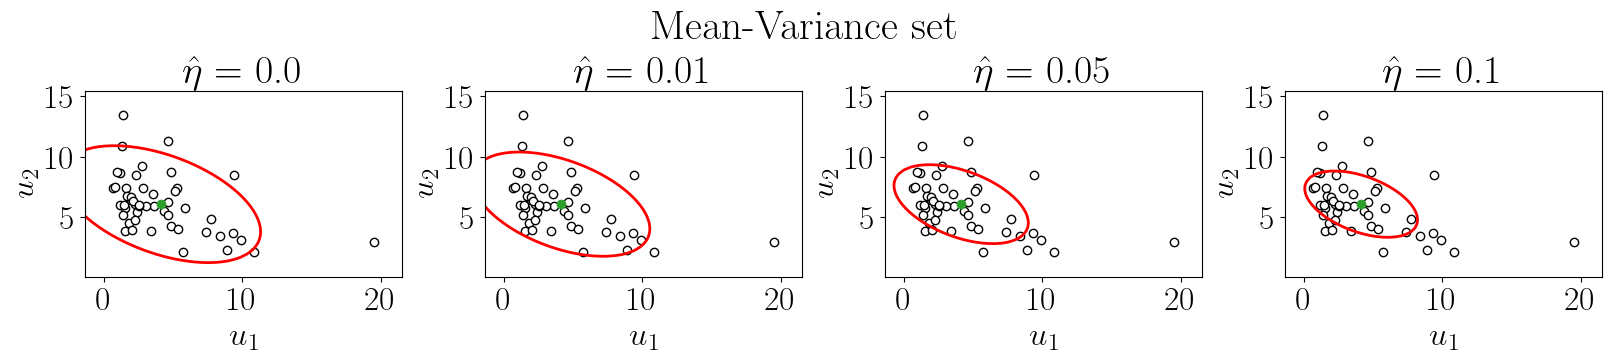

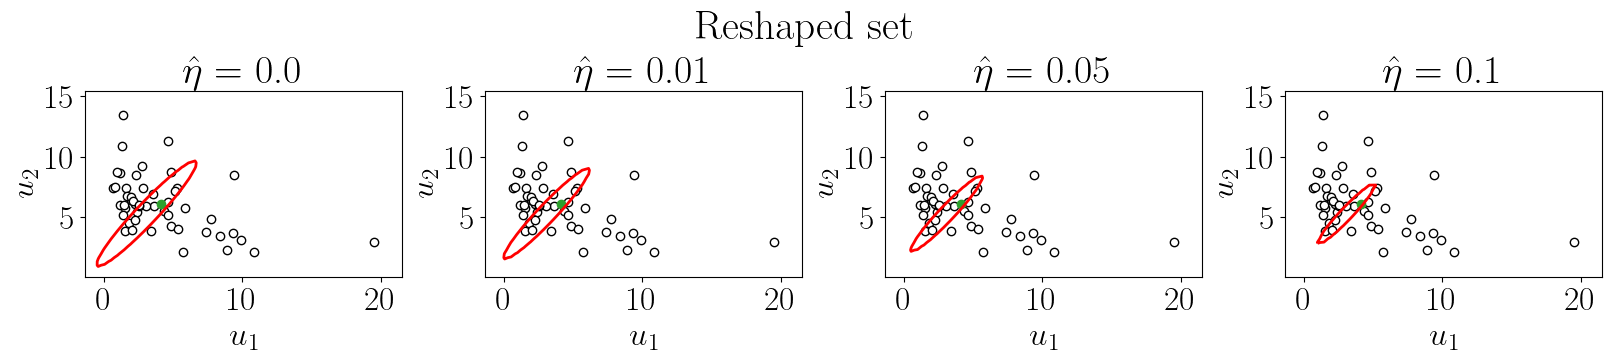

In [161]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,num_scenarios,train, "news_intro2",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,num_scenarios,train, "news_intro2",standard = False)

In [162]:
results_fin3 = {}
results_df3 = {}
results_grid3 = {}
seed = 13
N = 500
for reps in range(20):
  print(reps)
  # k = np.array([4.,5.])
  # num_scenarios = 10
  # num_reps = int(N/10)
  # k_data = k + np.random.normal(0,1,(num_scenarios,n))
  # p_data = k_data + np.maximum(0,np.random.normal(0,1,(num_scenarios,n)))
  # p_data = np.vstack([p_data]*num_reps)
  # k_data = np.vstack([k_data]*num_reps)
  indss = [5,9,13,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35]
  # data = gen_demand_intro(N, seed=list[reps])
  data = gen_demand_intro(N, seed=indss[reps])
  for etas in [0.3]:
# Formulate uncertainty set
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(
                                                        data=data))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    k = lropt.Parameter(2, data=k_data)
    p = lropt.Parameter(2, data=p_data)

    objective = cp.Minimize(t)
    constraints = [cp.maximum(-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])),-(p@np.array([1, 0]))*(x_r@np.array([1, 0])) -(p@np.array([0, 1]))*(u@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) -(p@np.array([0, 1]))*(x_r@np.array([0, 1])), -(p@np.array([1, 0]))*(u@np.array([1, 0])) - (p@np.array([0, 1]))*(u@np.array([0, 1]))) + k@x_r <= t]
    constraints += [x_r >= 0]


    eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

    prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)
    target = -0.0
    test_p = 0.90
    s = 8

    # setup intial A, b
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(np.cov(train.T))
    init_bval = np.mean(train, axis=0)

    np.random.seed(15)
    #initn = 5*np.random.rand(n,2)
    # initn = np.eye(n) + 5*np.random.rand(n,2)
    # init_bvaln = np.mean(train, axis=0)
    initn = sc.linalg.sqrtm(np.cov(train.T))
    init_bvaln = np.mean(train, axis=0)
    # Train A and b
    result = prob.train(lr=0.001, train_size = False, num_iter=500, optimizer="SGD",seed=5, init_A=initn, init_b=init_bvaln, init_lam=0.1, init_mu=0.1,
                        mu_multiplier=1.001, kappa=0., init_alpha=0., test_percentage = test_p,save_history = True, quantiles = (0.4,0.6), lr_step_size = 50, lr_gamma = 0.5, random_init = True, num_random_init = 5, parallel = True, position = False, eta=0.3)
    df = result.df
    A_fin = result.A
    b_fin = result.b
    results_fin3[(reps,etas)] = (A_fin,b_fin)
    results_df3[(reps,etas)] = df
    # Grid search epsilon
    eps_list = np.linspace(0.5, 2.5, 50)
    result4 = prob.grid(epslst=eps_list, init_A=init,
                        init_b=init_bval, seed=8,
                        init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
    dfgrid = result4.df

    result5 = prob.grid(epslst=eps_list,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6))
    dfgrid2 = result5.df
    dfgrid2 = result5.df
    results_grid3[(reps,etas)] = (dfgrid,dfgrid2)

0


python(96904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are know

1


/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

2


python(97207) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM 

3


python(97501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(97503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM 

4


/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
dfgrid, dfgrid2 = results_grid3[(0,0.3)]
dfgrid = dfgrid.drop(columns=["step","Probability_violations_test","var_values"])
dfgrid2 = dfgrid2.drop(columns=["step","Probability_violations_test","var_values"])
stacked = dfgrid["Test_val"]
stacked2 = dfgrid2["Test_val"]
# indss = np.array([9,10,12,13,16,18,19,20,22,23])
# indss = np.array([9,13,20,22])
indss = list(np.arange(1,20))
indss.remove(6)
indss.remove(19)
indss.remove(17)
indss.remove(15)
indss.remove(9)
#indss = [1,3,4,7]
#for reps in (indss-5):
for reps in indss:
  reps = int(reps)
  newgrid, newgrid2 = results_grid3[(reps,0.3)]
  newgrid = newgrid.drop(columns=["step","Probability_violations_test","var_values"])
  dfgrid = dfgrid.add(newgrid.reset_index(), fill_value=0)
  newgrid2 = newgrid2.drop(columns=["step","Probability_violations_test","var_values"])
  dfgrid2 = dfgrid2.add(newgrid2.reset_index(), fill_value=0)
  stacked = np.vstack([stacked,newgrid["Test_val"]])
  stacked2 = np.vstack([stacked2,newgrid2["Test_val"]])
dfgrid = dfgrid/(len(indss)+1)
dfgrid2 = dfgrid2/(len(indss)+1)
dfgrid["Lower_test"] = np.quantile(stacked,0.3,axis=0)
dfgrid["Upper_test"] = np.quantile(stacked,0.75,axis=0)
dfgrid2["Lower_test"] = np.quantile(stacked2,0.3,axis=0)
dfgrid2["Upper_test"] = np.quantile(stacked2,0.7,axis=0)
# dfgrid.to_csv("dfgrid_2")
# dfgrid2.to_csv("dfgrid2_2")
# np.save("stacked_2.npy",stacked)
# np.save("stacked2_2.npy",stacked2)

In [100]:
dfgrid, dfgrid2 = results_grid3[(0,0.3)]
A_fin,b_fin = results_fin3[(0,0.3)]

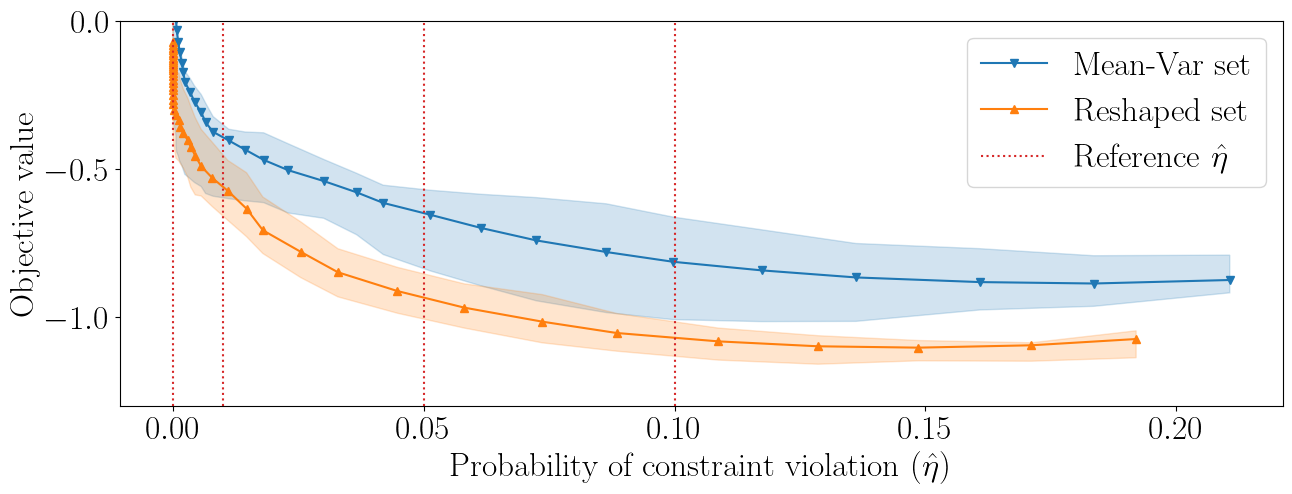

In [ ]:
# cur = 23
#0,1,3,4,5
#0,1,2,3,4,
#dfgrid, dfgrid2 = results_grid3[(1,0.3)]
beg1, end1 = 6, 100
beg2, end2 = 4, 100
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.fill(np.append(dfgrid['Avg_prob_test'][beg1:end1],dfgrid['Avg_prob_test'][beg1:end1][::-1]), np.append(dfgrid['Lower_test'][beg1:end1],dfgrid['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)
# for ind in range(4):
#     plt.scatter(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[inds_standard[ind]], np.mean(np.vstack(
#         dfgrid['Test_val']), axis=1)[inds_standard[ind]], color="tab:green", s=50, marker="v", zorder=10)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Reshaped set", marker="^", zorder=1)
plt.fill(np.append(dfgrid2['Avg_prob_test'][beg2:end2],dfgrid2['Avg_prob_test'][beg2:end2][::-1]), np.append(dfgrid2['Lower_test'][beg2:end2],dfgrid2['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)
# for ind in [0, 2, 1, 3]:
#     plt.scatter(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[inds_reshaped[ind]], np.mean(
#         np.vstack(dfgrid2['Test_val']), axis=1)[inds_reshaped[ind]], color="black", s=50, marker="^")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.xscale("log")
# plt.ylim([-3, 1])
# minv, maxv = (-0.25,-0.1)
minv, maxv = (-1.3,0.)
plt.vlines(ymin=minv, ymax=maxv, x=prob_list[0], linestyles=":",
           color="tab:red", label="Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin=minv, ymax=maxv, x=i, linestyles=":", color="tab:red")
plt.legend(loc="upper right")
plt.ylim([-1.3,0.])
plt.savefig("img_news_objective_vs_violations.pdf", bbox_inches='tight')

## GIF

In [34]:
A_fin = result1.A
b_fin = result1.b
A1_iters, b1_iters = result1.uncset_iters

In [35]:
def newsvendor_prob(A_final, b_final, scene):
    n = 2
    u = lropt.UncertainParameter(n,uncertainty_set=lropt.Ellipsoidal(p=2, A = A_final, b = b_final))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    k = scenarios[scene][0]
    p = scenarios[scene][1]
    # y = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
    # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

    constraints += [x_r >= 0]

    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    t_opt = t.value
    x_opt = x_r.value

    return x_opt, t_opt

In [36]:
offset = 1
x_min, x_max = np.min(train[:,0]) - 3*offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)

def optimal_sols(A_final, b_final, num_scenarios):
    x_opt = {}
    t_opt = {}
    for scene in range(num_scenarios):
        x_opt[scene], t_opt[scene] = newsvendor_prob(A_final, b_final, scene)
    return x_opt, t_opt

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh):
    unc_level_set = np.zeros((n,n))
    g_level_set = np.zeros((num_scenarios,n,n))
    x_opt,t_opt = optimal_sols(A_final, b_final, num_scenarios)
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            unc_level_set[i,j] = np.linalg.norm(A_final @ u_vec  + b_final)
            for scene in range(num_scenarios):
                g_level_set[scene,i,j] = np.maximum(scenarios[scene][0] @ x_opt[scene] - scenarios[scene][1] @ x_opt[scene], scenarios[scene][0] @ x_opt[scene] - scenarios[scene][1] @ u_vec) - t_opt[scene]

    return unc_level_set, g_level_set

In [37]:
unc_level_learned, g_level_learned = level_set(A_fin, b_fin)
unc_level_base, g_level_base = level_set(init, init_bval)

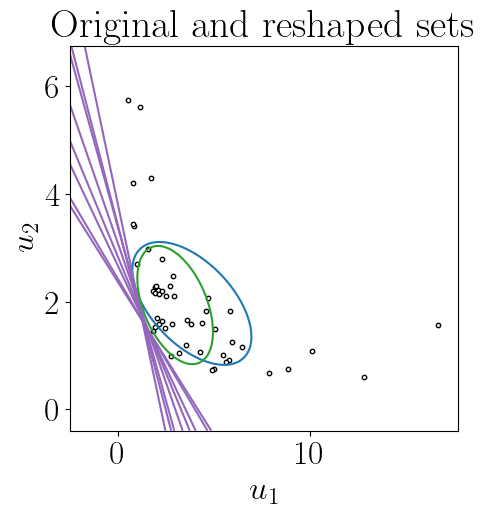

In [38]:
plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")
for scene in range(num_scenarios):
    plt.contour(x_mesh,y_mesh,g_level_learned[scene,:,:], [1], colors = ["tab:purple"], label = "Initial Set")
    # plt.contour(x_mesh,y_mesh,g_level_base[scene,:,:], [1], colors = ["tab:green"], label = "Final Set")

plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()

In [41]:
import os
import imageio

filenames = []
for i in range(len(A1_iters)):
    # 
    unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    plt.figure(figsize=(5, 5))
    plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    plt.xlabel(r"$u_1$")
    plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
    plt.contour(x_mesh,y_mesh,unc_level, [1], colors = ["tab:red"], label = "trained Set")
    plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")
    for scene in range(num_scenarios):
        plt.contour(x_mesh,y_mesh,g_level[scene,:,:], [1], colors = ["tab:purple"], label = "Initial Set")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('gifs/newsvendor.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)